In [1]:
using Revise
using DifferentialEquations
using Flux
using DiffEqFlux
using Optim
using Plots
using FileIO
using JLD2
using OffsetArrays
using Kinetic

In [23]:
function bgk!(df, f, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [3]:
D = read_dict("../code/shock/shock1D.txt")
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = shock
space = 1d1f1v
nSpecies = 1
interpOrder = 1
limiter = vanleer
cfl = 0.95
maxTime = 250.0
x0 = -25.0
x1 = 25.0
nx = 50
pMeshType = uniform
nxg = 0
umin = -10.0
umax = 10.0
nu = 36
nug = 0
vMeshType = rectangle
knudsen = 1.0
mach = 2.0
prandtl = 1.0
inK = 0.0
omega = 0.5
alphaRef = 1.0
omegaRef = 0.5
tLen = 5
nh = 12



In [4]:
γ = 3.
set = Setup(case, space, nSpecies, interpOrder, limiter, cfl, maxTime)
pSpace = PSpace1D(x0, x1, nx, pMeshType, nxg)
μᵣ = ref_vhs_vis(knudsen, alphaRef, omegaRef)
gas = GasProperty(knudsen, mach, prandtl, inK, γ, omega, alphaRef, omegaRef, μᵣ)
vSpace = VSpace1D(umin, umax, nu, vMeshType, nug)
wL, primL, fL, bcL, wR, primR, fR, bcR = ib_rh(mach, γ, vSpace.u)
ib = IB1D1F(wL, primL, fL, bcL, wR, primR, fR, bcR)

ks = SolverSet(set, pSpace, vSpace, gas, ib, pwd());

In [78]:
ctr = OffsetArray{ControlVolume1D1F}(undef, eachindex(ks.pSpace.x))
face = Array{Interface1D1F}(undef, ks.pSpace.nx+1)
for i in eachindex(ctr)
    if i <= ks.pSpace.nx÷2
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wL), Float32.(ks.ib.primL), Float32.(ks.ib.fL))
    else
        ctr[i] = ControlVolume1D1F(ks.pSpace.x[i], ks.pSpace.dx[i], Float32.(ks.ib.wR), Float32.(ks.ib.primR), Float32.(ks.ib.fR))
    end
end
for i=1:ks.pSpace.nx+1
    face[i] = Interface1D1F(ks.ib.fL)
end

In [79]:
sos = sound_speed(ks.ib.primR, γ)
vmax = ks.vSpace.u1 + sos
tmax = vmax / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tSpan = (0.f0, dt)
tRan = range(tSpan[1], tSpan[2], length=tLen)

0.0f0:0.01935499f0:0.07741996f0

In [82]:
residual = Array{Float32}(undef, 3)
for iter=1:1000
    Kinetic.evolve!(ks, ctr, face, dt)
    Kinetic.update!(ks, ctr, face, dt, residual)
end

In [32]:
X = Array{Float32}(undef, nu, nx);
for i in 1:nx
    X[:,i] .= ctr[i].f
end

In [28]:
M = Array{Float32}(undef, nu, nx)
τ = Array{Float32}(undef, nx)
for i=1:nx
    M[:,i] .= maxwellian(ks.vSpace.u, ctr[i].prim)
    τ = vhs_collision_time(ctr[i].prim, ks.gas.μᵣ, ks.gas.ω)
end

data_para = [M, τ];

In [35]:
prob = ODEProblem(bgk!, X, tSpan, data_para)
Y = solve(prob, Tsit5(), saveat=tRan) |> Array;

In [31]:
dudt = FastChain( (x, p) -> x.^3,
                   FastDense(vSpace.nu, vSpace.nu*16, tanh),
                   #FastDense(vSpace.nu*16, vSpace.nu*16, tanh),
                   FastDense(vSpace.nu*16, vSpace.nu) )
#node = NeuralODE(dudt, tSpan, Tsit5(), saveat=tRan)
node = NeuralODE(dudt, tSpan, Tsit5(), saveat=tRan)

(::NeuralODE{FastChain{Tuple{var"#7#8",FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#76"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(identity),DiffEqFlux.var"#initial_params#76"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}}}},Array{Float32,1},Nothing,Tuple{Float32,Float32},Tsit5,Tuple{},Base.Iterators.Pairs{Symbol,StepRangeLen{Float32,Float64,Float64},Tuple{Symbol},NamedTuple{(:saveat,),Tuple{StepRangeLen{Float32,Float64,Float64}}}}}) (generic function with 4 methods)

In [36]:
function loss_node(p) # without dataset
    diff = Array(node(X, p)) .- Y
    loss = sum(abs2, diff)
    return loss
end

loss_node (generic function with 1 method)

In [37]:
cb = function (p, l)
    display(l)
    return false
end

#9 (generic function with 1 method)

In [38]:
#res = DiffEqFlux.sciml_train(loss_node, node.p, ADAM(), dataset, cb=cb, maxiters=100)
res = DiffEqFlux.sciml_train(loss_node, node.p, ADAM(), cb=Flux.throttle(cb, 1), maxiters=1000)

0.007033267f0

loss: 0.0027:   0%|▏                                        |  ETA: 8:16:129m

0.0023652627f0

loss: 0.0028:   1%|▎                                        |  ETA: 2:48:46m

0.0021913862f0

loss: 0.00199:   1%|▍                                        |  ETA: 1:43:30

0.002195115f0

loss: 0.00195:   1%|▋                                        |  ETA: 1:15:25

0.0017368281f0

loss: 0.00161:   2%|▊                                        |  ETA: 0:59:51

0.0016872857f0

loss: 0.0016:   2%|▉                                        |  ETA: 0:49:56m

0.0015002575f0

loss: 0.00143:   3%|█▏                                       |  ETA: 0:43:05

0.001448647f0

loss: 0.00139:   3%|█▎                                       |  ETA: 0:38:08

0.001333887f0

loss: 0.00125:   3%|█▍                                       |  ETA: 0:34:24

0.0012545224f0

loss: 0.00121:   4%|█▌                                       |  ETA: 0:31:23

0.0011786661f0

loss: 0.00111:   4%|█▊                                       |  ETA: 0:29:00

0.0011021354f0

loss: 0.00105:   5%|█▉                                       |  ETA: 0:27:00

0.0010231682f0

loss: 0.000967:   5%|██                                       |  ETA: 0:25:17

0.00095331355f0

loss: 0.000918:   5%|██▏                                      |  ETA: 0:24:13

0.0008971514f0

loss: 0.000839:   6%|██▍                                      |  ETA: 0:22:56

0.0008228309f0

loss: 0.000769:   6%|██▌                                      |  ETA: 0:21:47

0.0007495944f0

loss: 0.000697:   6%|██▋                                      |  ETA: 0:20:48

0.0006804962f0

loss: 0.000645:   7%|██▊                                      |  ETA: 0:20:10

0.0006270728f0

loss: 0.000577:   7%|███                                      |  ETA: 0:19:22

0.00056062324f0

loss: 0.000528:   8%|███▏                                     |  ETA: 0:18:49

0.0005113963f0

loss: 0.000465:   8%|███▎                                     |  ETA: 0:18:10

0.00045053533f0

loss: 0.000407:   8%|███▍                                     |  ETA: 0:17:32

0.0003929626f0

loss: 0.000367:   9%|███▌                                     |  ETA: 0:17:08

0.00035359192f0

loss: 0.000317:   9%|███▊                                     |  ETA: 0:16:37

0.0003053186f0

loss: 0.000273:   9%|███▉                                     |  ETA: 0:16:08

0.00026282354f0

loss: 0.000235:  10%|████                                     |  ETA: 0:15:41

0.00022631088f0

loss: 0.000203:  10%|████▏                                    |  ETA: 0:15:17

0.00019545367f0

loss: 0.000176:  11%|████▍                                    |  ETA: 0:14:54

0.00017015173f0

loss: 0.000155:  11%|████▌                                    |  ETA: 0:14:33

0.00014993569f0

loss: 0.000142:  11%|████▋                                    |  ETA: 0:14:19

0.00013769409f0

loss: 0.000128:  12%|████▊                                    |  ETA: 0:13:59

0.00012480776f0

loss: 0.000117:  12%|█████                                    |  ETA: 0:13:42

0.00011517411f0

loss: 0.00011:  12%|█████▏                                   |  ETA: 0:13:25m

0.00010810862f0

loss: 0.000104:  13%|█████▎                                   |  ETA: 0:13:09

0.00010301203f0

loss: 0.0001:  13%|█████▌                                   |  ETA: 0:12:539m

9.9365716f-5

loss: 9.73e-05:  14%|█████▋                                   |  ETA: 0:12:39

9.674905f-5

loss: 9.53e-05:  14%|█████▊                                   |  ETA: 0:12:25

9.484506f-5

loss: 9.37e-05:  14%|██████                                   |  ETA: 0:12:11

9.342622f-5

loss: 9.26e-05:  15%|██████▏                                  |  ETA: 0:11:58

9.2333714f-5

loss: 9.17e-05:  15%|██████▎                                  |  ETA: 0:11:46

9.146174f-5

loss: 9.09e-05:  16%|██████▍                                  |  ETA: 0:11:33

9.074061f-5

loss: 9.03e-05:  16%|██████▋                                  |  ETA: 0:11:22

9.012543f-5

loss: 8.97e-05:  16%|██████▊                                  |  ETA: 0:11:11

8.95856f-5

loss: 8.92e-05:  17%|██████▉                                  |  ETA: 0:11:01

8.90997f-5

loss: 8.88e-05:  17%|███████▏                                 |  ETA: 0:10:51

8.865244f-5

loss: 8.83e-05:  18%|███████▎                                 |  ETA: 0:10:41

8.823234f-5

loss: 8.79e-05:  18%|███████▍                                 |  ETA: 0:10:31

8.782951f-5

loss: 8.75e-05:  18%|███████▋                                 |  ETA: 0:10:22

8.743754f-5

loss: 8.71e-05:  19%|███████▊                                 |  ETA: 0:10:14

8.7051805f-5

loss: 8.68e-05:  19%|███████▉                                 |  ETA: 0:10:05

8.6668166f-5

loss: 8.64e-05:  20%|████████▏                                |  ETA: 0:09:57

8.6284694f-5

loss: 8.6e-05:  20%|████████▎                                |  ETA: 0:09:50m

8.5899774f-5

loss: 8.56e-05:  20%|████████▍                                |  ETA: 0:09:42

8.551312f-5

loss: 8.52e-05:  21%|████████▋                                |  ETA: 0:09:35

8.5123946f-5

loss: 8.48e-05:  21%|████████▊                                |  ETA: 0:09:29

8.4732805f-5

loss: 8.44e-05:  22%|████████▉                                |  ETA: 0:09:22

8.433881f-5

loss: 8.4e-05:  22%|█████████                                |  ETA: 0:09:16m

8.394255f-5

loss: 8.37e-05:  22%|█████████▏                               |  ETA: 0:09:11

8.364286f-5

loss: 8.33e-05:  23%|█████████▍                               |  ETA: 0:09:05

8.324322f-5

loss: 8.29e-05:  23%|█████████▌                               |  ETA: 0:08:59

8.2840685f-5

loss: 8.26e-05:  24%|█████████▋                               |  ETA: 0:08:55

8.253658f-5

loss: 8.23e-05:  24%|█████████▊                               |  ETA: 0:08:51

8.2232174f-5

loss: 8.19e-05:  24%|█████████▉                               |  ETA: 0:08:45

8.18244f-5

loss: 8.15e-05:  25%|██████████▏                              |  ETA: 0:08:40

8.1425984f-5

loss: 8.12e-05:  25%|██████████▎                              |  ETA: 0:08:35

8.1230275f-5

loss: 8.1e-05:  25%|██████████▍                              |  ETA: 0:08:29m

8.116879f-5

loss: 8.31e-05:  26%|██████████▌                              |  ETA: 0:08:25

8.548419f-5

loss: 9e-05:  26%|██████████▊                              |  ETA: 0:08:2039m

8.4290084f-5

loss: 8.48e-05:  26%|██████████▉                              |  ETA: 0:08:15

8.523325f-5

loss: 8.06e-05:  27%|███████████                              |  ETA: 0:08:10

8.2632825f-5

loss: 7.9e-05:  27%|███████████▎                             |  ETA: 0:08:05m

8.024966f-5

loss: 7.85e-05:  28%|███████████▍                             |  ETA: 0:07:59

7.870378f-5

loss: 7.84e-05:  28%|███████████▌                             |  ETA: 0:07:54

7.792053f-5

loss: 7.83e-05:  28%|███████████▋                             |  ETA: 0:07:50

7.765199f-5

loss: 7.78e-05:  29%|███████████▉                             |  ETA: 0:07:45

7.750273f-5

loss: 7.7e-05:  29%|████████████                             |  ETA: 0:07:42m

7.706019f-5

loss: 7.66e-05:  30%|████████████▏                            |  ETA: 0:07:37

7.642366f-5

loss: 7.63e-05:  30%|████████████▎                            |  ETA: 0:07:33

7.61041f-5

loss: 7.58e-05:  30%|████████████▌                            |  ETA: 0:07:28

7.5746495f-5

loss: 7.55e-05:  31%|████████████▋                            |  ETA: 0:07:25

7.531191f-5

loss: 7.51e-05:  31%|████████████▊                            |  ETA: 0:07:21

7.497339f-5

loss: 7.47e-05:  31%|████████████▉                            |  ETA: 0:07:18

7.459319f-5

loss: 7.43e-05:  32%|█████████████                            |  ETA: 0:07:14

7.422541f-5

loss: 7.39e-05:  32%|█████████████▎                           |  ETA: 0:07:10

7.377075f-5

loss: 7.36e-05:  32%|█████████████▍                           |  ETA: 0:07:07

7.347604f-5

loss: 7.32e-05:  33%|█████████████▌                           |  ETA: 0:07:03

7.306432f-5

loss: 7.27e-05:  33%|█████████████▋                           |  ETA: 0:06:59

7.263185f-5

loss: 7.23e-05:  34%|█████████████▉                           |  ETA: 0:06:55

7.22122f-5

loss: 7.19e-05:  34%|██████████████                           |  ETA: 0:06:51

7.179826f-5

loss: 7.15e-05:  34%|██████████████▏                          |  ETA: 0:06:47

7.140639f-5

loss: 7.12e-05:  35%|██████████████▎                          |  ETA: 0:06:43

7.1217015f-5

loss: 7.22e-05:  35%|██████████████▌                          |  ETA: 0:06:39

7.348529f-5

loss: 8.59e-05:  36%|██████████████▋                          |  ETA: 0:06:35

9.179835f-5

loss: 7.4e-05:  36%|██████████████▊                          |  ETA: 0:06:32m

6.9783186f-5

loss: 7.95e-05:  36%|███████████████                          |  ETA: 0:06:28

7.287688f-5

loss: 7.57e-05:  37%|███████████████▏                         |  ETA: 0:06:24

7.449989f-5

loss: 7.11e-05:  37%|███████████████▎                         |  ETA: 0:06:21

7.280453f-5

loss: 6.86e-05:  38%|███████████████▌                         |  ETA: 0:06:17

7.0141265f-5

loss: 6.8e-05:  38%|███████████████▋                         |  ETA: 0:06:13m

6.8138615f-5

loss: 6.82e-05:  38%|███████████████▊                         |  ETA: 0:06:10

6.741987f-5

loss: 6.81e-05:  39%|████████████████                         |  ETA: 0:06:06

6.7479596f-5

loss: 6.72e-05:  39%|████████████████▏                        |  ETA: 0:06:03

6.721771f-5

loss: 6.63e-05:  40%|████████████████▎                        |  ETA: 0:05:59

6.637123f-5

loss: 6.61e-05:  40%|████████████████▌                        |  ETA: 0:05:56

6.581317f-5

loss: 6.57e-05:  40%|████████████████▋                        |  ETA: 0:05:53

6.5589964f-5

loss: 6.51e-05:  41%|████████████████▊                        |  ETA: 0:05:49

6.502794f-5

loss: 6.48e-05:  41%|████████████████▉                        |  ETA: 0:05:46

6.4635635f-5

loss: 6.43e-05:  42%|█████████████████▏                       |  ETA: 0:05:43

6.421682f-5

loss: 6.39e-05:  42%|█████████████████▎                       |  ETA: 0:05:40

6.380071f-5

loss: 6.35e-05:  42%|█████████████████▍                       |  ETA: 0:05:37

6.336739f-5

loss: 6.31e-05:  43%|█████████████████▋                       |  ETA: 0:05:34

6.2989835f-5

loss: 6.27e-05:  43%|█████████████████▊                       |  ETA: 0:05:30

6.257591f-5

loss: 6.23e-05:  44%|█████████████████▉                       |  ETA: 0:05:27

6.222767f-5

loss: 6.21e-05:  44%|██████████████████▏                      |  ETA: 0:05:24

6.195507f-5

loss: 6.14e-05:  44%|██████████████████▎                      |  ETA: 0:05:21

6.132755f-5

loss: 6.11e-05:  45%|██████████████████▍                      |  ETA: 0:05:18

6.0957274f-5

loss: 6.08e-05:  45%|██████████████████▋                      |  ETA: 0:05:15

6.0801893f-5

loss: 6.22e-05:  46%|██████████████████▊                      |  ETA: 0:05:12

6.432328f-5

loss: 9.16e-05:  46%|██████████████████▉                      |  ETA: 0:05:09

0.00010963529f0

loss: 6.86e-05:  46%|███████████████████▏                     |  ETA: 0:05:06

6.0603546f-5

loss: 7.48e-05:  47%|███████████████████▎                     |  ETA: 0:05:03

5.9453676f-5

loss: 7.09e-05:  47%|███████████████████▍                     |  ETA: 0:05:00

5.941987f-5

loss: 6.64e-05:  48%|███████████████████▌                     |  ETA: 0:04:57

5.8778216f-5

loss: 6.31e-05:  48%|███████████████████▊                     |  ETA: 0:04:54

5.8188925f-5

loss: 6.09e-05:  48%|███████████████████▉                     |  ETA: 0:04:51

5.774133f-5

loss: 5.95e-05:  49%|████████████████████                     |  ETA: 0:04:49

5.7363337f-5

loss: 5.85e-05:  49%|████████████████████▎                    |  ETA: 0:04:46

5.7021283f-5

loss: 5.78e-05:  50%|████████████████████▍                    |  ETA: 0:04:43

5.6714234f-5

loss: 5.72e-05:  50%|████████████████████▌                    |  ETA: 0:04:40

5.6439792f-5

loss: 5.66e-05:  50%|████████████████████▊                    |  ETA: 0:04:38

5.616949f-5

loss: 5.6e-05:  51%|████████████████████▉                    |  ETA: 0:04:35m

5.5848326f-5

loss: 5.54e-05:  51%|█████████████████████                    |  ETA: 0:04:32

5.5425684f-5

loss: 5.49e-05:  52%|█████████████████████▎                   |  ETA: 0:04:29

5.491376f-5

loss: 5.45e-05:  52%|█████████████████████▍                   |  ETA: 0:04:27

5.442002f-5

loss: 5.42e-05:  52%|█████████████████████▌                   |  ETA: 0:04:24

5.4043754f-5

loss: 5.38e-05:  53%|█████████████████████▊                   |  ETA: 0:04:22

5.3720854f-5

loss: 5.34e-05:  53%|█████████████████████▉                   |  ETA: 0:04:19

5.332489f-5

loss: 5.3e-05:  54%|██████████████████████                   |  ETA: 0:04:16m

5.2926167f-5

loss: 5.27e-05:  54%|██████████████████████▏                  |  ETA: 0:04:14

5.2577823f-5

loss: 5.23e-05:  54%|██████████████████████▍                  |  ETA: 0:04:11

5.218877f-5

loss: 5.19e-05:  55%|██████████████████████▌                  |  ETA: 0:04:08

5.1826937f-5

loss: 5.15e-05:  55%|██████████████████████▋                  |  ETA: 0:04:06

5.144799f-5

loss: 5.12e-05:  56%|██████████████████████▉                  |  ETA: 0:04:03

5.1084833f-5

loss: 5.08e-05:  56%|███████████████████████                  |  ETA: 0:04:00

5.0710638f-5

loss: 5.04e-05:  56%|███████████████████████▏                 |  ETA: 0:03:58

5.033886f-5

loss: 5.01e-05:  57%|███████████████████████▍                 |  ETA: 0:03:55

4.99707f-5

loss: 4.97e-05:  57%|███████████████████████▌                 |  ETA: 0:03:53

4.9605605f-5

loss: 4.93e-05:  58%|███████████████████████▋                 |  ETA: 0:03:50

4.9261784f-5

loss: 4.91e-05:  58%|███████████████████████▉                 |  ETA: 0:03:48

4.9143564f-5

loss: 5.06e-05:  58%|████████████████████████                 |  ETA: 0:03:45

5.241267f-5

loss: 7.83e-05:  59%|████████████████████████▏                |  ETA: 0:03:43

0.00010070009f0

loss: 9.43e-05:  59%|████████████████████████▍                |  ETA: 0:03:40

5.474258f-5

loss: 8.84e-05:  60%|████████████████████████▌                |  ETA: 0:03:38

6.484706f-5

loss: 7.33e-05:  60%|████████████████████████▋                |  ETA: 0:03:35

6.166933f-5

loss: 6.39e-05:  60%|████████████████████████▊                |  ETA: 0:03:33

5.6720983f-5

loss: 5.8e-05:  61%|█████████████████████████                |  ETA: 0:03:30m

5.2905725f-5

loss: 5.41e-05:  61%|█████████████████████████▏               |  ETA: 0:03:28

5.0422394f-5

loss: 5.13e-05:  62%|█████████████████████████▎               |  ETA: 0:03:26

4.886203f-5

loss: 4.94e-05:  62%|█████████████████████████▌               |  ETA: 0:03:23

4.7858397f-5

loss: 4.79e-05:  62%|█████████████████████████▋               |  ETA: 0:03:21

4.713776f-5

loss: 4.6e-05:  63%|█████████████████████████▊               |  ETA: 0:03:19m

4.6789693f-5

loss: 4.54e-05:  63%|█████████████████████████▉               |  ETA: 0:03:17

4.5879453f-5

loss: 4.51e-05:  64%|██████████████████████████▏              |  ETA: 0:03:15

4.51628f-5

loss: 4.51e-05:  64%|██████████████████████████▎              |  ETA: 0:03:13

4.480482f-5

loss: 4.48e-05:  64%|██████████████████████████▍              |  ETA: 0:03:11

4.4580684f-5

loss: 4.43e-05:  65%|██████████████████████████▌              |  ETA: 0:03:08

4.426147f-5

loss: 4.38e-05:  65%|██████████████████████████▊              |  ETA: 0:03:06

4.383387f-5

loss: 4.35e-05:  66%|██████████████████████████▉              |  ETA: 0:03:04

4.3429434f-5

loss: 4.32e-05:  66%|███████████████████████████              |  ETA: 0:03:01

4.313742f-5

loss: 4.29e-05:  66%|███████████████████████████▏             |  ETA: 0:02:59

4.284278f-5

loss: 4.26e-05:  67%|███████████████████████████▍             |  ETA: 0:02:57

4.2491236f-5

loss: 4.23e-05:  67%|███████████████████████████▌             |  ETA: 0:02:54

4.2192056f-5

loss: 4.2e-05:  67%|███████████████████████████▋             |  ETA: 0:02:53m

4.1950785f-5

loss: 4.17e-05:  68%|███████████████████████████▊             |  ETA: 0:02:50

4.1650033f-5

loss: 4.14e-05:  68%|████████████████████████████             |  ETA: 0:02:48

4.133561f-5

loss: 4.11e-05:  69%|████████████████████████████▏            |  ETA: 0:02:46

4.103521f-5

loss: 4.08e-05:  69%|████████████████████████████▎            |  ETA: 0:02:44

4.072361f-5

loss: 4.05e-05:  69%|████████████████████████████▌            |  ETA: 0:02:41

4.041969f-5

loss: 4.03e-05:  70%|████████████████████████████▋            |  ETA: 0:02:40

4.0194576f-5

loss: 4e-05:  70%|████████████████████████████▊            |  ETA: 0:02:3839m

3.9896844f-5

loss: 3.97e-05:  70%|████████████████████████████▉            |  ETA: 0:02:35

3.9614562f-5

loss: 3.95e-05:  71%|█████████████████████████████            |  ETA: 0:02:34

3.9460574f-5

loss: 3.95e-05:  71%|█████████████████████████████▏           |  ETA: 0:02:32

3.961237f-5

loss: 4.18e-05:  72%|█████████████████████████████▍           |  ETA: 0:02:30

4.43154f-5

loss: 5.85e-05:  72%|█████████████████████████████▌           |  ETA: 0:02:28

7.480677f-5

loss: 0.000131:  72%|█████████████████████████████▋           |  ETA: 0:02:26

9.891292f-5

loss: 6.48e-05:  73%|█████████████████████████████▊           |  ETA: 0:02:24

8.470699f-5

loss: 4.21e-05:  73%|█████████████████████████████▉           |  ETA: 0:02:22

4.3041236f-5

loss: 4.5e-05:  73%|██████████████████████████████           |  ETA: 0:02:20

3.882247f-5

loss: 4.45e-05:  74%|██████████████████████████████▎          |  ETA: 0:02:18

3.794395f-5

loss: 4.92e-05:  74%|██████████████████████████████▍          |  ETA: 0:02:16

4.3088166f-5

loss: 4.5e-05:  74%|██████████████████████████████▌          |  ETA: 0:02:14m

4.1801064f-5

loss: 4.21e-05:  75%|██████████████████████████████▋          |  ETA: 0:02:12

4.0740862f-5

loss: 3.99e-05:  75%|██████████████████████████████▉          |  ETA: 0:02:10

3.9777082f-5

loss: 3.69e-05:  76%|███████████████████████████████          |  ETA: 0:02:08

3.8218262f-5

loss: 3.66e-05:  76%|███████████████████████████████▏         |  ETA: 0:02:06

3.7039285f-5

loss: 3.75e-05:  76%|███████████████████████████████▎         |  ETA: 0:02:05

3.6587793f-5

loss: 3.7e-05:  77%|███████████████████████████████▍         |  ETA: 0:02:02m

3.6590383f-5

loss: 3.64e-05:  77%|███████████████████████████████▋         |  ETA: 0:02:00

3.6382622f-5

loss: 3.58e-05:  77%|███████████████████████████████▊         |  ETA: 0:01:58

3.5912562f-5

loss: 3.56e-05:  78%|███████████████████████████████▉         |  ETA: 0:01:57

3.5436628f-5

loss: 3.54e-05:  78%|████████████████████████████████         |  ETA: 0:01:54

3.5299385f-5

loss: 3.51e-05:  78%|████████████████████████████████▏        |  ETA: 0:01:53

3.5070116f-5

loss: 3.5e-05:  79%|████████████████████████████████▎        |  ETA: 0:01:51m

3.4853005f-5

loss: 3.47e-05:  79%|████████████████████████████████▍        |  ETA: 0:01:50

3.467891f-5

loss: 3.45e-05:  79%|████████████████████████████████▌        |  ETA: 0:01:47

3.4383367f-5

loss: 3.42e-05:  80%|████████████████████████████████▊        |  ETA: 0:01:45

3.4175042f-5

loss: 3.4e-05:  80%|████████████████████████████████▉        |  ETA: 0:01:43m

3.3898075f-5

loss: 3.37e-05:  81%|█████████████████████████████████        |  ETA: 0:01:41

3.3666263f-5

loss: 3.35e-05:  81%|█████████████████████████████████▎       |  ETA: 0:01:39

3.3412594f-5

loss: 3.32e-05:  81%|█████████████████████████████████▍       |  ETA: 0:01:37

3.3180655f-5

loss: 3.3e-05:  82%|█████████████████████████████████▌       |  ETA: 0:01:34m

3.2931744f-5

loss: 3.28e-05:  82%|█████████████████████████████████▋       |  ETA: 0:01:33

3.27547f-5

loss: 3.26e-05:  82%|█████████████████████████████████▉       |  ETA: 0:01:31

3.252335f-5

loss: 3.23e-05:  83%|██████████████████████████████████       |  ETA: 0:01:29

3.2289787f-5

loss: 3.21e-05:  83%|██████████████████████████████████▏      |  ETA: 0:01:26

3.2062337f-5

loss: 3.19e-05:  84%|██████████████████████████████████▍      |  ETA: 0:01:24

3.186629f-5

loss: 3.18e-05:  84%|██████████████████████████████████▌      |  ETA: 0:01:22

3.1900414f-5

loss: 3.31e-05:  84%|██████████████████████████████████▋      |  ETA: 0:01:20

3.436928f-5

loss: 4.16e-05:  85%|██████████████████████████████████▊      |  ETA: 0:01:18

5.0358474f-5

loss: 0.000122:  85%|██████████████████████████████████▉      |  ETA: 0:01:16

0.0001418487f0

loss: 3.33e-05:  86%|███████████████████████████████████▏     |  ETA: 0:01:14

4.3154712f-5

loss: 5.11e-05:  86%|███████████████████████████████████▎     |  ETA: 0:01:12

3.1058316f-5

loss: 5.2e-05:  86%|███████████████████████████████████▍     |  ETA: 0:01:10m

3.296392f-5

loss: 4.7e-05:  87%|███████████████████████████████████▋     |  ETA: 0:01:08m

3.383782f-5

loss: 4.21e-05:  87%|███████████████████████████████████▊     |  ETA: 0:01:06

3.3731154f-5

loss: 3.84e-05:  88%|███████████████████████████████████▉     |  ETA: 0:01:04

3.33429f-5

loss: 3.56e-05:  88%|████████████████████████████████████▏    |  ETA: 0:01:02

3.290326f-5

loss: 3.34e-05:  88%|████████████████████████████████████▎    |  ETA: 0:00:59

3.2401305f-5

loss: 3.17e-05:  89%|████████████████████████████████████▍    |  ETA: 0:00:57

3.1770327f-5

loss: 3.05e-05:  89%|████████████████████████████████████▋    |  ETA: 0:00:55

3.0993087f-5

loss: 2.97e-05:  90%|████████████████████████████████████▊    |  ETA: 0:00:53

3.0164145f-5

loss: 2.93e-05:  90%|████████████████████████████████████▉    |  ETA: 0:00:51

2.947401f-5

loss: 2.96e-05:  90%|█████████████████████████████████████    |  ETA: 0:00:50

2.9250243f-5

loss: 2.92e-05:  91%|█████████████████████████████████████▏   |  ETA: 0:00:48

2.931909f-5

loss: 2.89e-05:  91%|█████████████████████████████████████▎   |  ETA: 0:00:46

2.8891163f-5

loss: 2.89e-05:  91%|█████████████████████████████████████▍   |  ETA: 0:00:44

2.8724631f-5

loss: 2.86e-05:  92%|█████████████████████████████████████▋   |  ETA: 0:00:42

2.8586448f-5

loss: 2.84e-05:  92%|█████████████████████████████████████▊   |  ETA: 0:00:41

2.8330389f-5

loss: 2.83e-05:  92%|█████████████████████████████████████▉   |  ETA: 0:00:39

2.8240778f-5

loss: 2.81e-05:  93%|██████████████████████████████████████   |  ETA: 0:00:38

2.8047189f-5

loss: 2.8e-05:  93%|██████████████████████████████████████▏  |  ETA: 0:00:36

2.7940174f-5

loss: 2.78e-05:  93%|██████████████████████████████████████▎  |  ETA: 0:00:35

2.7768434f-5

loss: 2.77e-05:  94%|██████████████████████████████████████▍  |  ETA: 0:00:33

2.7650622f-5

loss: 2.75e-05:  94%|██████████████████████████████████████▌  |  ETA: 0:00:32

2.7493123f-5

loss: 2.74e-05:  94%|██████████████████████████████████████▋  |  ETA: 0:00:30

2.7368515f-5

loss: 2.73e-05:  94%|██████████████████████████████████████▊  |  ETA: 0:00:29

2.7228283f-5

loss: 2.71e-05:  95%|██████████████████████████████████████▉  |  ETA: 0:00:27

2.7089438f-5

loss: 2.7e-05:  95%|███████████████████████████████████████  |  ETA: 0:00:26m

2.6961628f-5

loss: 2.69e-05:  95%|███████████████████████████████████████▏ |  ETA: 0:00:24

2.6825872f-5

loss: 2.67e-05:  96%|███████████████████████████████████████▎ |  ETA: 0:00:22

2.6647884f-5

loss: 2.66e-05:  96%|███████████████████████████████████████▍ |  ETA: 0:00:21

2.6519461f-5

loss: 2.64e-05:  96%|███████████████████████████████████████▌ |  ETA: 0:00:19

2.6390215f-5

loss: 2.63e-05:  97%|███████████████████████████████████████▋ |  ETA: 0:00:18

2.6260534f-5

loss: 2.62e-05:  97%|███████████████████████████████████████▊ |  ETA: 0:00:16

2.6131498f-5

loss: 2.6e-05:  97%|███████████████████████████████████████▉ |  ETA: 0:00:14m

2.6003789f-5

loss: 2.59e-05:  98%|████████████████████████████████████████ |  ETA: 0:00:13

2.5878035f-5

loss: 2.58e-05:  98%|████████████████████████████████████████▏|  ETA: 0:00:11

2.5755944f-5

loss: 2.57e-05:  98%|████████████████████████████████████████▎|  ETA: 0:00:10

2.5646927f-5

loss: 2.56e-05:  98%|████████████████████████████████████████▍|  ETA: 0:00:08

2.5605405f-5

loss: 2.57e-05:  99%|████████████████████████████████████████▌|  ETA: 0:00:07

2.5979532f-5

loss: 2.74e-05:  99%|████████████████████████████████████████▋|  ETA: 0:00:05

2.9321247f-5

loss: 5.49e-05:  99%|████████████████████████████████████████▊|  ETA: 0:00:03

8.0588456f-5

loss: 0.000166: 100%|████████████████████████████████████████▉|  ETA: 0:00:02

0.00018258273f0

loss: 5.15e-05: 100%|█████████████████████████████████████████| Time: 0:08:38


2.5602874f-5

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [9.89e-02, 6.73e-02, 9.42e-03,  ...]
    Minimum:   5.153166e-05

 * Found with
    Algorithm:     ADAM
    Initial Point: [9.89e-02, 6.73e-02, 9.42e-03,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   520  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1000
    ∇f(x) calls:   1000


In [ ]:
#res = DiffEqFlux.sciml_train(loss_node, res.minimizer, ADAM(), dataset, cb=Flux.throttle(cb, 1), maxiters=1000)
res = DiffEqFlux.sciml_train(loss_node, res.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=1000)

In [77]:
res = DiffEqFlux.sciml_train(loss_node, res.minimizer, LBFGS(), cb=cb, maxiters=200)

2.7505059f-5

2.5261848f-5

2.5125444f-5

2.5108217f-5

2.5107085f-5

2.5106376f-5

2.5091309f-5

2.5021587f-5

2.5010315f-5

2.4998393f-5

2.491719f-5

2.4896297f-5

2.489218f-5

2.4881672f-5

2.4724848f-5

2.4657655f-5

2.4639392f-5

2.4636383f-5

2.461237f-5

2.4563975f-5

2.4561123f-5

2.4558585f-5

2.4509052f-5

2.4332632f-5

2.4314202f-5

2.42915f-5

2.425595f-5

2.4144743f-5

2.3966497f-5

2.3925153f-5

2.3813187f-5

2.2128948f-5

2.1430416f-5

2.1388232f-5

2.1138963f-5

2.0930196f-5

2.0671374f-5

2.0591733f-5

2.0550551f-5

2.0500378f-5

2.0433092f-5

2.0280453f-5

2.0115891f-5

2.0073025f-5

2.0045398f-5

1.998879f-5

1.997186f-5

1.9953559f-5

1.9855552f-5

1.9732226f-5

1.971037f-5

1.967701f-5

1.9482068f-5

1.9224313f-5

1.9085639f-5

1.8779005f-5

1.852987f-5

1.8510584f-5

1.8503404f-5

1.846265f-5

1.8337316f-5

1.8300965f-5

1.828151f-5

1.8214461f-5

1.8102613f-5

1.8065164f-5

1.7993858f-5

 * Status: failure

 * Candidate solution
    Minimizer: [9.89e-02, 6.73e-02, 9.42e-03,  ...]
    Minimum:   1.799386e-05

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [9.89e-02, 6.73e-02, 9.42e-03,  ...]

 * Convergence measures
    |x - x'|               = 1.01e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.44e-03 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.13e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.96e-03 ≰ 0.0e+00
    |g(x)|                 = 1.03e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   84  (vs limit Inf)
    Iterations:    66
    f(x) calls:    202
    ∇f(x) calls:   202


In [46]:
function step_train!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG, datainit, dataset )
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    data = solve(ODEProblem(bgk!, f[1:end], tSpan, [M, τ]), Tsit5(), saveat=tRan) |> Array;
    pred = n_ode(f[1:end], p) |> Array
    loss = sum(abs2, pred .- data)

    if loss <= 1.e-6
        ftemp = n_ode(f[1:end], p).u[end]
    	for i in eachindex(u)
    		f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    	end
    else
        for i in eachindex(u)
    		f[i] += (ffL[i] - ffR[i]) / dx + (M[i] - f[i]) / τ * tRan[end]
    	end
        
        #push!(datainit, f[1:end])
        #push!(dataset, data)
    end
end

function step_bgk!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG, datainit, dataset )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    prim_old = deepcopy(prim)
    
    #--- update W^{n+1} ---#
	@. w = w_old + (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)
    
    M = maxwellian(u, prim_old)
	τ = vhs_collision_time(prim_old, μ, ω)
    
    #ftemp = f .+ (M .- f) / τ * tRan[end]
    prob = ODEProblem(bgk!, f[1:end], (0, tRan[end]), (M, τ))
    ftemp = (solve(prob, Tsit5(), saveat=tRan) |> Array)[:,end]
    
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end
    
end

function step_node!( fwL, ffL, w, prim, f, fwR, ffR,
			           γ, μ, ω, u, n_ode, p, dx, tRan, RES, AVG, datainit, dataset )
    
    #--- record W^{n} ---#
    w_old = deepcopy(w)
    M = maxwellian(u, prim)
	τ = vhs_collision_time(prim, μ, ω)
    
    #--- update W^{n+1} ---#
	@. w += (fwL - fwR) / dx
	prim .= conserve_prim(w, γ)

	#--- record residuals ---#
	@. RES += (w - w_old)^2
	@. AVG += abs(w)

    ftemp = n_ode(f[1:end], p).u[end]
    for i in eachindex(u)
        f[i] = ftemp[i] + (ffL[i] - ffR[i]) / dx
    end

end

step_node! (generic function with 1 method)

In [104]:
sumRes = zeros(Float32, axes(ib.wL))
sumAvg = zeros(Float32, axes(ib.wL))
for iter = 1:100

    Kinetic.evolve!(ks, ctr, face, dt)
#=
    for i in 2:10
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end

    for i in 2:35
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end
    =#
    for i in 2:49
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_bgk!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end

end

for iter = 1:010

    Kinetic.evolve!(ks, ctr, face, dt)
#=
    for i in 2:10
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end

    for i in 2:35
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end
    =#
    for i in 2:49
        #step_train!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
        #             face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, n_ode, res.minimizer,
        #             ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
        step_node!( face[i].fw, face[i].ff, ctr[i].w, ctr[i].prim, ctr[i].f,
                     face[i+1].fw, face[i+1].ff, ks.gas.γ, ks.gas.μᵣ, ks.gas.ω, vSpace.u, node, res.minimizer,
                     ctr[i].dx, tRan, sumRes, sumAvg, data_init, data_boltz )
    end

end

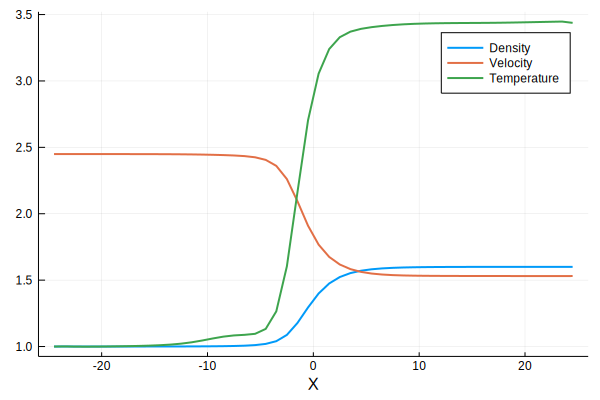

In [105]:
plot_line(ks, ctr)

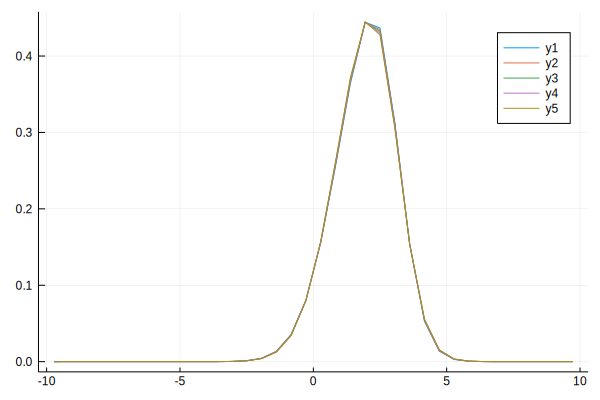

In [39]:
plot(vSpace.u, node(ctr[25].f[1:end], res.minimizer).u)

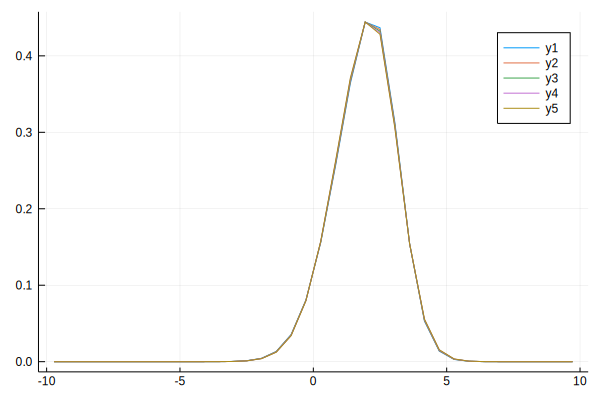

In [42]:
plot(vSpace.u, Y[:,25,:])